In [1]:
# Importing packages
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2025-07-29 16:08:12.536536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753805292.725640      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753805292.774003      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Path to the dataset
data_path = "/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset"

# Tumor classes
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Initialize lists to store images, masks, and labels
images = []
masks = []
labels = []
# Desired size for images and masks
target_size = (128, 128)

# Load images and masks
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))
    mask_folder = os.path.join(data_path, 'mask', str(classes.index(class_name)))
    
    # Check if the folders exist
    if os.path.exists(image_folder) and os.path.exists(mask_folder):
        # Load images
        for image_name in tqdm(os.listdir(image_folder), desc=class_name):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Check for image format
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size) 
                image = image / 255.0
                
                # Check for the corresponding mask name
                mask_name = image_name.replace('.jpg', '_m.jpg').replace('.png', '_m.png')
                mask_path = os.path.join(mask_folder, mask_name)

                # Load the mask only if it exists
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, target_size) 
                    mask = mask / 255.0
                    
                    # Add images and masks to the lists
                    images.append(image)
                    masks.append(mask)
                    labels.append(classes.index(class_name))
                
                else:
                    print(f"Mask missing for image: {image_name}")

# Convert lists to NumPy arrays
images = np.array(images).reshape(-1, 128, 128, 1)
masks = np.array(masks).reshape(-1, 128, 128, 1)
labels = np.array(labels)

# Display the dimensions of the datasets
print(f"Number of images: {len(images)}, Number of masks: {len(masks)}, Number of labels: {len(labels)}")

no_tumor:   0%|          | 0/1595 [00:00<?, ?it/s]

glioma_tumor:   0%|          | 0/649 [00:00<?, ?it/s]

meningioma_tumor:   0%|          | 0/999 [00:00<?, ?it/s]

pituitary_tumor:   0%|          | 0/994 [00:00<?, ?it/s]

Number of images: 4237, Number of masks: 4237, Number of labels: 4237


In [3]:
# Count the number of images per class
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))

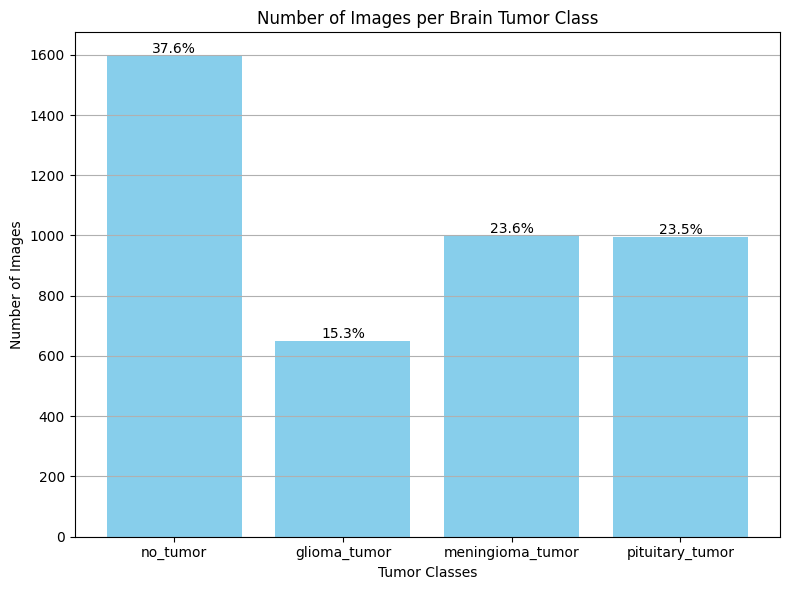

In [4]:
# Count the number of images per class
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))

# Calculate the total number of images and percentages
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Add percentages above the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Tumor Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Brain Tumor Class')
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

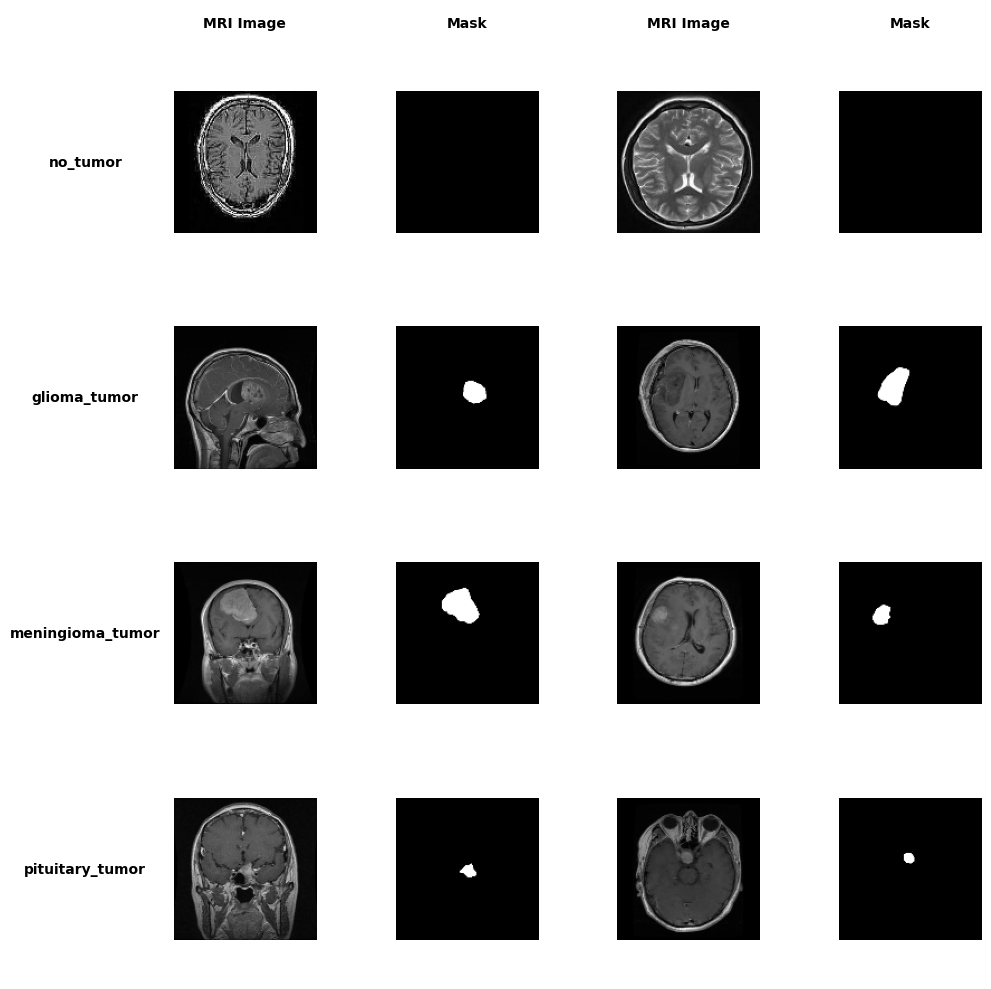

In [5]:
# Initialize figure with a grid for 4 classes
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(10, 10), 
                         gridspec_kw={'width_ratios': [0.5, 4, 4, 4 ,4], 'height_ratios': [0.5, 4, 4, 4, 4]})

# Column titles
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')  # Remove axes

axs[0, 1].text(0.5, 0.5, "MRI Image", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')  # Remove axes

axs[0, 2].text(0.5, 0.5, "Mask", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')  # Remove axes

axs[0, 3].text(0.5, 0.5, "MRI Image", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')  # Remove axes

axs[0, 4].text(0.5, 0.5, "Mask", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')  # Remove axes

for i, class_name in enumerate(classes):
    # Find an image and mask index for each class
    class_index = classes.index(class_name)
    
    # Retrieve an example image and mask for each class
    example_index1 = np.where(labels == class_index)[0][0]  # Take the first example of each class
    example_index2 = np.where(labels == class_index)[0][2]  # Take the second example 
    image1 = images[example_index1]
    mask1 = masks[example_index1]
    
    image2 = images[example_index2]
    mask2 = masks[example_index2]
    
    # Display the image
    axs[i + 1, 1].imshow(image1, cmap='gray')
    axs[i + 1, 1].axis('off')  # Remove axes

    # Display the mask
    axs[i + 1, 2].imshow(mask1, cmap='gray')
    axs[i + 1, 2].axis('off')  # Remove axes
    
    # Display the image
    axs[i + 1, 3].imshow(image2, cmap='gray')
    axs[i + 1, 3].axis('off')  # Remove axes

    # Display the mask
    axs[i + 1, 4].imshow(mask2, cmap='gray')
    axs[i + 1, 4].axis('off')  # Remove axes

    # Center the text in the class column
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')  # Remove axes

plt.tight_layout()
plt.show()

In [6]:
# Split the data into training (75%) and validation (25%) sets
images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
    images, masks, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True
)

# Display the dimensions of the datasets
print(f"Training set - Images: {images_train.shape}, Masks: {masks_train.shape}, Labels: {labels_train.shape}")
print(f"Validation set - Images: {images_val.shape}, Masks: {masks_val.shape}, Labels: {labels_val.shape}")

Training set - Images: (2965, 128, 128, 1), Masks: (2965, 128, 128, 1), Labels: (2965,)
Validation set - Images: (1272, 128, 128, 1), Masks: (1272, 128, 128, 1), Labels: (1272,)


In [7]:
# Function to create a generator that applies the same augmentation to images and masks
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Generators for images and masks
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)
    
    while True:
        # Generate a batch of images and masks
        img_batch = next(image_generator)  # Use `next(image_generator)`
        mask_batch = next(mask_generator)  # Use `next(mask_generator)`
        
        yield img_batch, mask_batch

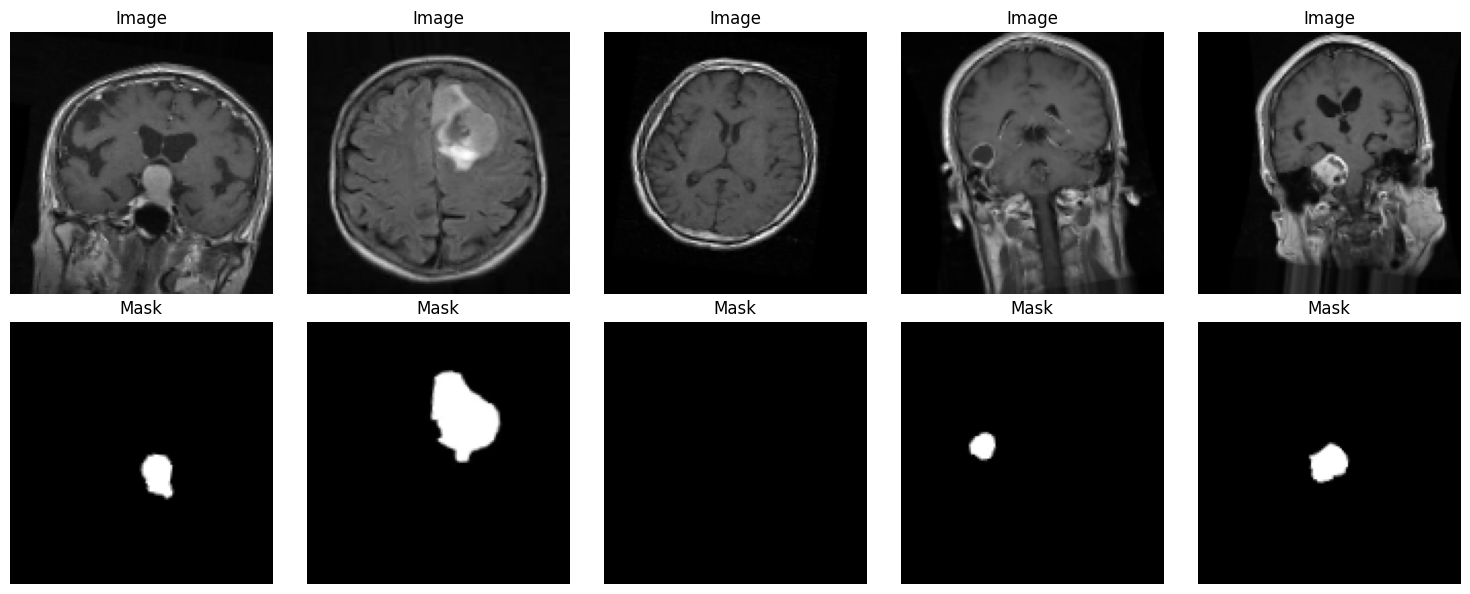

In [8]:
# Function to display images and their corresponding masks
def plot_images(images, masks, num_images=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Display the image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')  # Adjust shape if needed
        plt.axis('off')
        plt.title('Image')

        # Display the corresponding mask
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')  # Adjust shape if needed
        plt.axis('off')
        plt.title('Mask')
    
    plt.tight_layout()
    plt.show()

# Test the augmentation generator by taking a few images
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))

# Display the images and masks
plot_images(images_batch, masks_batch, num_images=5)

In [9]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (to be used as a loss function)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Hausdorff Loss
import tensorflow as tf

def compute_dtm(img, max_distance):
    """
    Computes the distance transform map for the binary image.
    
    Args:
        img (tf.Tensor): Binary image (batch, height, width, channels).
        max_distance (int): Maximum distance to clip the distance map.
        
    Returns:
        tf.Tensor: Distance transform map.
    """
    img = tf.cast(img, tf.float32)
    img = 1 - img  # Invert image so that distance is computed to zero pixels
    dt = tf.py_function(func=lambda x: tf.image.distance_transform_edt(x), inp=[img], Tout=tf.float32)
    dt = tf.clip_by_value(dt, 0, max_distance)
    return dt

def hausdorff_loss(y_true, y_pred, smooth=1):
    """
    Computes the Hausdorff distance loss between the predicted and ground truth masks.
    
    Args:
        y_true (tf.Tensor): Ground truth binary masks (batch, height, width, channels).
        y_pred (tf.Tensor): Predicted binary masks (batch, height, width, channels).
        smooth (float): Smoothing term to avoid division by zero.
        
    Returns:
        tf.Tensor: Hausdorff loss value.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Compute the distance transform maps
    dt_true = compute_dtm(y_true, max_distance=128)
    dt_pred = compute_dtm(y_pred, max_distance=128)

    # Calculate loss based on the distance `
    hd_loss_1 = tf.reduce_mean(y_pred * (dt_true ** 2))
    hd_loss_2 = tf.reduce_mean(y_true * (dt_pred ** 2))

    # Final Hausdorff loss
    hausdorff_loss_value = hd_loss_1 + hd_loss_2 + smooth
    return hausdorff_loss_value   

# Intersection over Union (IoU)
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

In [10]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck (bottom layer)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer with a single channel, for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model


# Define the input shape (height, width, channels)
hausdorff_loss = 'binary_crossentropy'
input_shape = (128, 128, 1) 
model = unet_model(input_shape)
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=hausdorff_loss, metrics=['accuracy', dice_coefficient, iou])

I0000 00:00:1753805388.477545      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define the callbacks
model_checkpoint = ModelCheckpoint('best_unetmodel.keras',  # File name to save the best model
                                   monitor='val_dice_coefficient',  # Track the validation Dice Coefficient value
                                   save_best_only=True,  # Save only the best model
                                   mode='max',  # Look for the maximum value
                                   verbose=1  # Display a message when saving the model
                                  )

early_stopping = EarlyStopping(monitor='val_dice_coefficient',
                               patience=10,  # Stop after 10 epochs without improvement
                               mode='max',  # Look for the maximum value
                               verbose=1  # Display a message when stopping
                              )

# Use the augmentation generator for training
batch_size = 32
train_gen = train_generator(images_train, masks_train, batch_size=batch_size)

# Train the model with the generator
history = model.fit(
    train_gen,
    steps_per_epoch=len(images_train) // batch_size,
    epochs=100,
    validation_data=(images_val, masks_val),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/100


I0000 00:00:1753805399.826503      98 service.cc:148] XLA service 0x7aaa40002290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753805399.827117      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753805400.911153      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753805426.878910      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9849 - dice_coefficient: 0.0129 - iou: 0.0065 - loss: 0.3568
Epoch 1: val_dice_coefficient improved from -inf to 0.05106, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 399ms/step - accuracy: 0.9849 - dice_coefficient: 0.0129 - iou: 0.0066 - loss: 0.3548 - val_accuracy: 0.9874 - val_dice_coefficient: 0.0511 - val_iou: 0.0262 - val_loss: 0.0556
Epoch 2/100


E0000 00:00:1753805468.802212      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753805469.039273      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9851 - dice_coefficient: 0.0364 - iou: 0.0186 - loss: 0.0476
Epoch 2: val_dice_coefficient improved from 0.05106 to 0.05420, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.9851 - dice_coefficient: 0.0364 - iou: 0.0186 - loss: 0.0476 - val_accuracy: 0.9874 - val_dice_coefficient: 0.0542 - val_iou: 0.0279 - val_loss: 0.0544
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9858 - dice_coefficient: 0.0413 - iou: 0.0212 - loss: 0.0435
Epoch 3: val_dice_coefficient improved from 0.05420 to 0.06093, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.9858 - dice_coefficient: 0.0413 - iou: 0.0212 - loss: 0.0435 - val_accuracy: 0.9874 - val_dice_coefficient: 0.0609 - val_iou: 0.0315 - val_loss: 0.0446
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9851 - dice_coefficient: 0.0443 - iou: 0.0228 - loss: 0.0464
Epoch 4: v

In [12]:
# Evaluate the model on the training set
train_loss, train_accuracy, train_dice_coef, train_iou_coef = model.evaluate(images_train, masks_train, verbose=1)
print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Dice Coefficient: {train_dice_coef:.4f}')
print(f'Training IoU Coefficient: {train_iou_coef:.4f}')

92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9948 - dice_coefficient: 0.8878 - iou: 0.7987 - loss: 0.0038

E0000 00:00:1753807538.364225     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753807538.601409     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9948 - dice_coefficient: 0.8879 - iou: 0.7988 - loss: 0.0038
Training Loss: 0.0036
Training Accuracy: 0.9950
Training Dice Coefficient: 0.8899
Training IoU Coefficient: 0.8022


In [13]:
# Evaluate the model on the validation set
val_loss, val_accuracy, val_dice_coef, val_iou_coef = model.evaluate(images_val, masks_val, verbose=1)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Dice Coefficient: {val_dice_coef:.4f}')
print(f'Validation IoU Coefficient: {val_iou_coef:.4f}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9946 - dice_coefficient: 0.8660 - iou: 0.7656 - loss: 0.0055
Validation Loss: 0.0054
Validation Accuracy: 0.9946
Validation Dice Coefficient: 0.8667
Validation IoU Coefficient: 0.7664


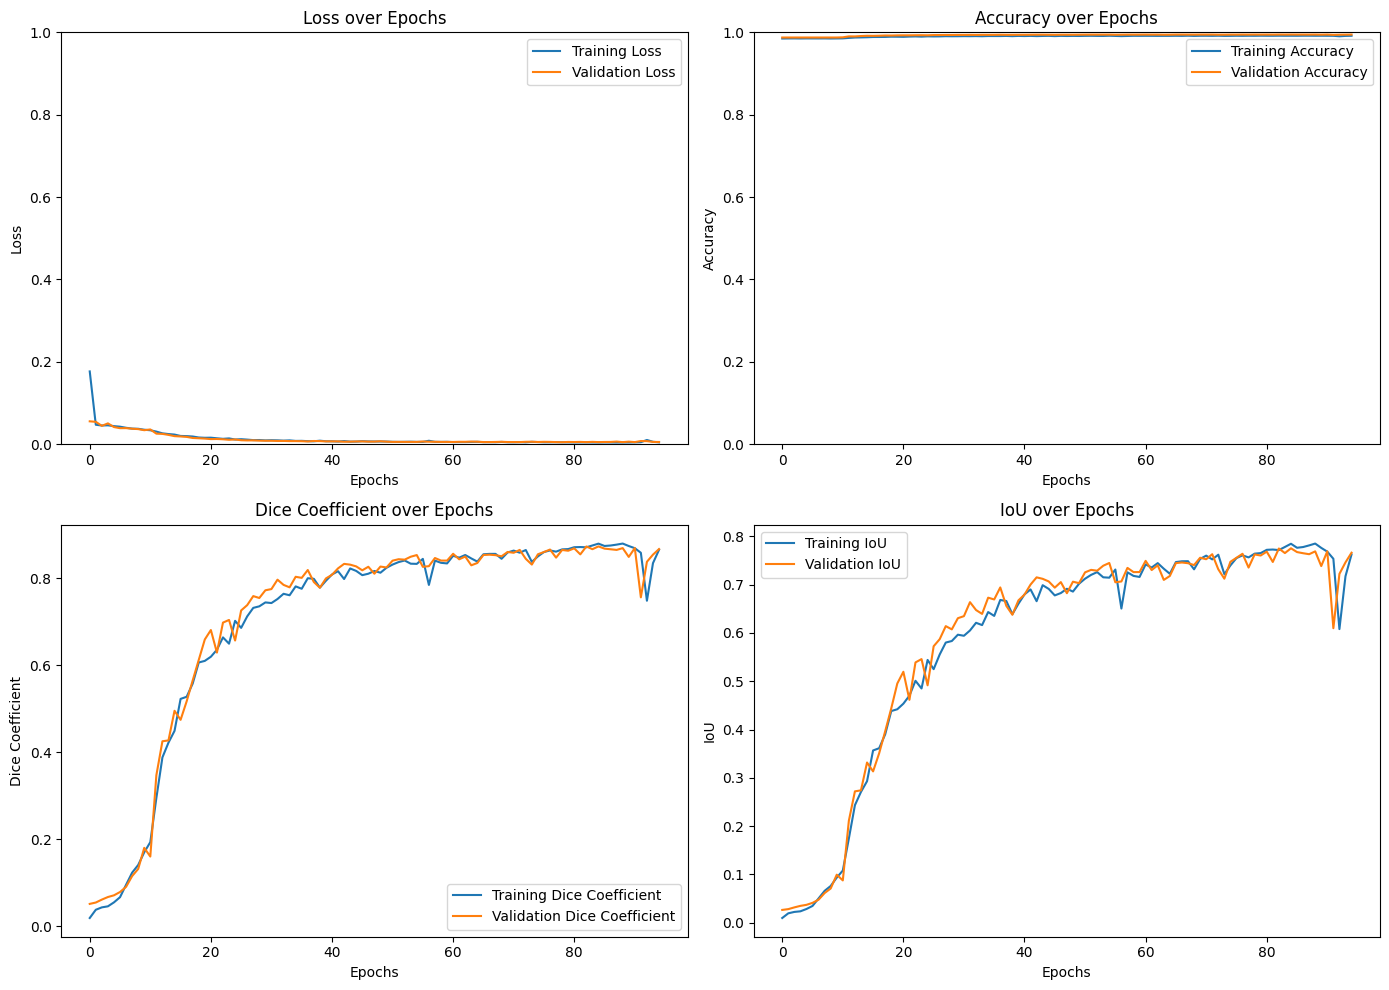

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot the Loss curve
axs[0, 0].plot(history.history['loss'], label='Training Loss')
axs[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Loss over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].legend()

# Plot the Accuracy curve
axs[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axs[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0, 1].set_title('Accuracy over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_ylim(0, 1)  # Corrected from axs[0, 0] to axs[0, 1]
axs[0, 1].legend()

# Plot the Dice Coefficient curve
axs[1, 0].plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
axs[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
axs[1, 0].set_title('Dice Coefficient over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Dice Coefficient')
axs[1, 0].legend()

# Plot the IoU curve
axs[1, 1].plot(history.history['iou'], label='Training IoU')
axs[1, 1].plot(history.history['val_iou'], label='Validation IoU')
axs[1, 1].set_title('IoU over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IoU')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [16]:
# Predictions on a validation set
predictions = model.predict(images_val)
predictions = (predictions > 0.5).astype(np.uint8)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step


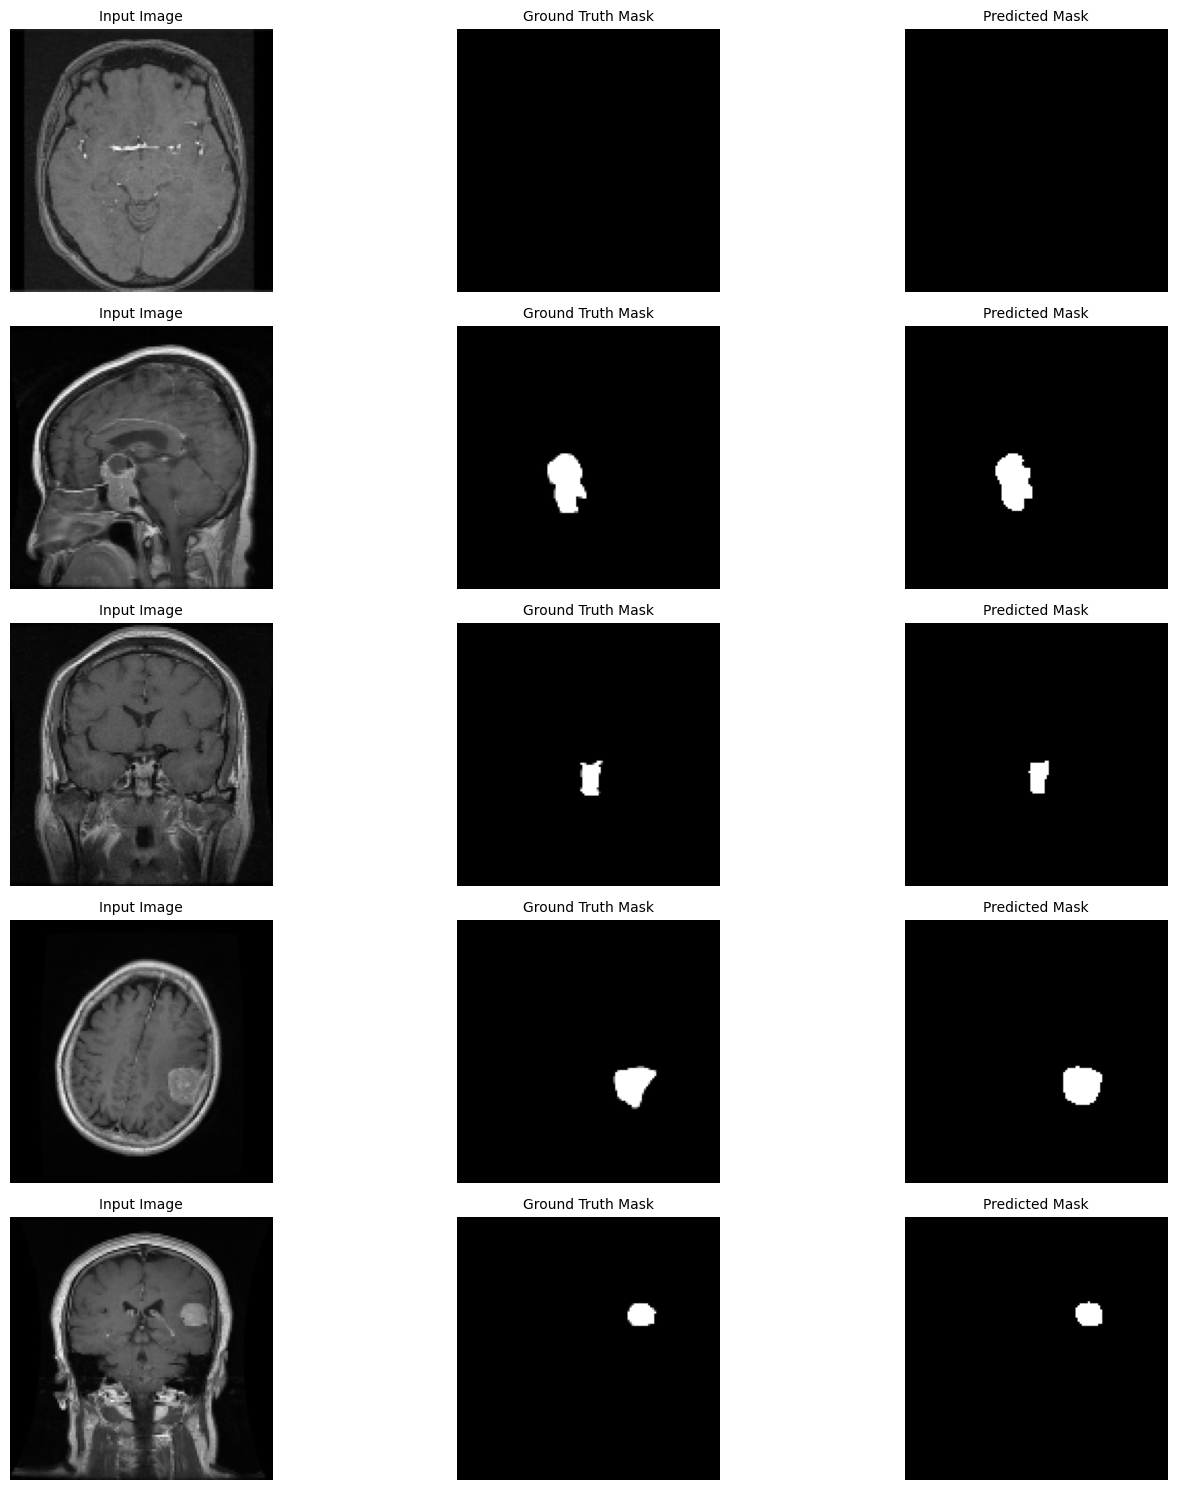

In [17]:
# Visualize a few results
n = 5  # Number of examples to display
plt.figure(figsize=(15, 15))

for i in range(n):
    # Input image
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(images_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Input Image', fontsize=10)
    plt.axis('off')

    # Ground truth mask
    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(masks_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Ground Truth Mask', fontsize=10)
    plt.axis('off')

    # Predicted mask
    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(predictions[i+1].reshape(128, 128), cmap='gray')
    plt.title('Predicted Mask', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


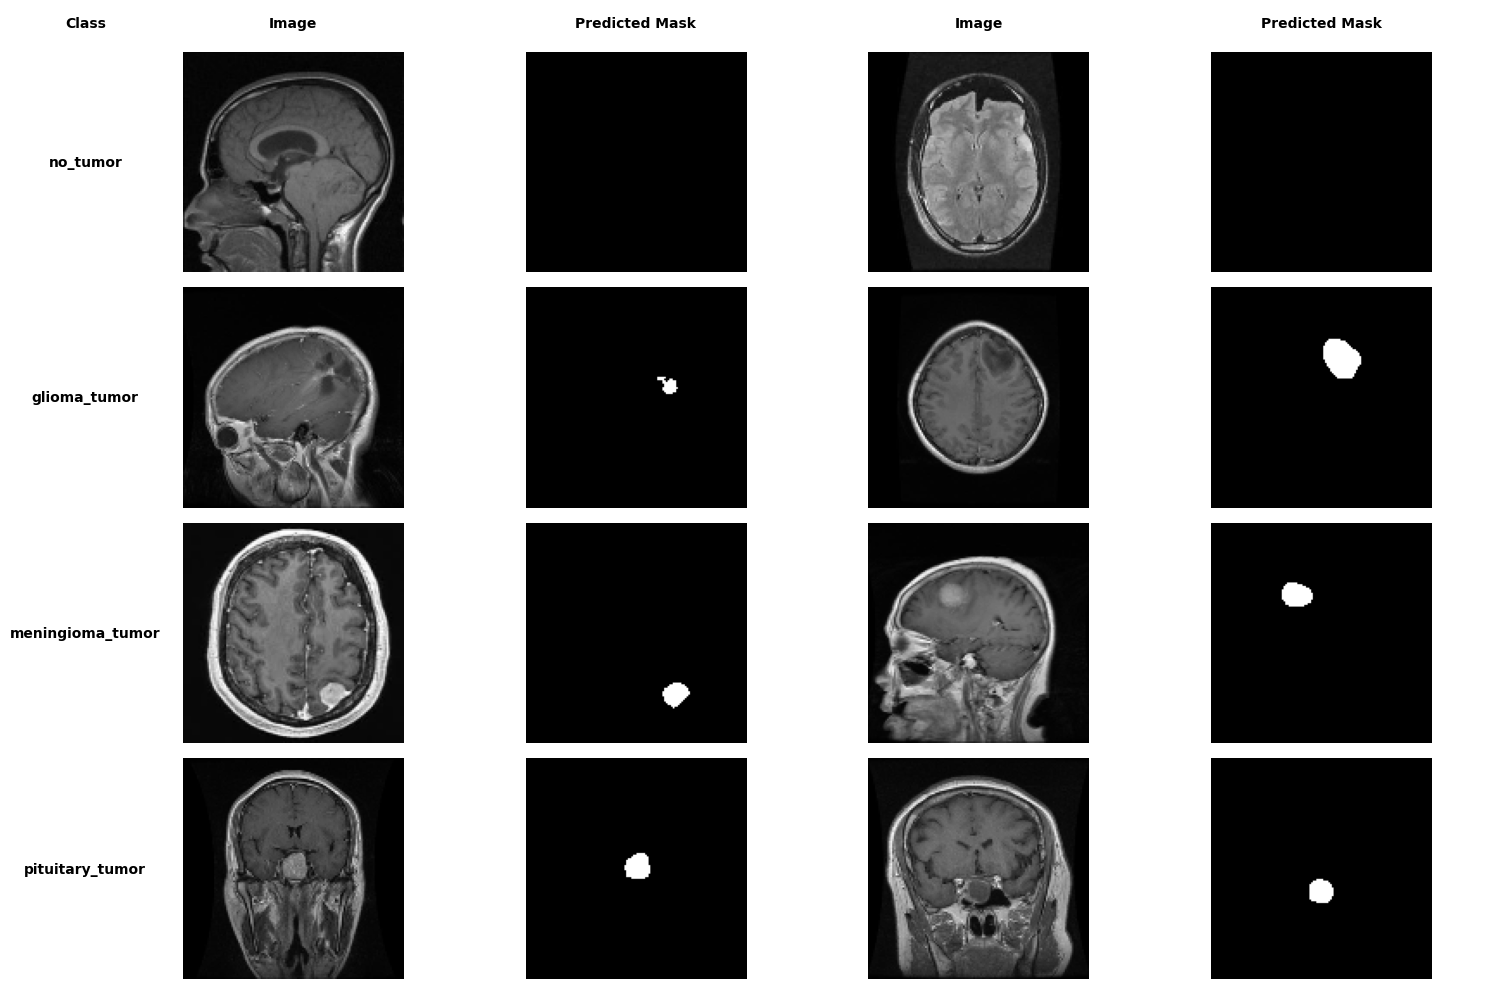

In [18]:
# Path to the test dataset
test_dir = '/kaggle/input/brain-tumor-classification-mri/Training'

# Load two images from each class for testing
test_images = []
test_labels = []

for class_name in classes:
    class_folder = os.path.join(test_dir, class_name)
    
    # Get the names of the test images
    image_names = os.listdir(class_folder)
    
    # Ensure there are at least 2 images
    if len(image_names) >= 2:
        for image_name in image_names[:2]:  # Take the first two images from each class
            image_path = os.path.join(class_folder, image_name)
            
            # Load and preprocess the image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, target_size)
            image = image / 255.0
            image = np.expand_dims(image, axis=-1)  # Add the channel dimension
            
            test_images.append(image)
            test_labels.append(class_name)

# Convert to a NumPy array
test_images = np.array(test_images)

# Make predictions on these new images
test_predictions = model.predict(test_images)
test_predictions = (test_predictions > 0.5).astype(np.uint8)

# Initialize the figure with a grid for each class
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(15, 10), 
                         gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})

# Column titles
titles = ["Class", "Image", "Predicted Mask", "Image", "Predicted Mask"]
for j in range(5):
    axs[0, j].text(0.5, 0.5, titles[j], fontsize=10, ha='center', va='center', fontweight='bold')
    axs[0, j].axis('off')

# Display the images and their predictions
for i, class_name in enumerate(classes):
    class_indices = [j for j, label in enumerate(test_labels) if label == class_name]
    
    if len(class_indices) >= 2:  # Check if there are at least 2 indices for the class
        example_index1 = class_indices[0]
        example_index2 = class_indices[1]

        # Display the class name
        axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
        axs[i + 1, 0].axis('off')  # Remove the axes
        
        # Display the first image
        axs[i + 1, 1].imshow(test_images[example_index1].squeeze(), cmap='gray')
        axs[i + 1, 1].axis('off')  # Remove the axes

        # Display the predicted mask for the first image
        axs[i + 1, 2].imshow(test_predictions[example_index1], cmap='gray')
        axs[i + 1, 2].axis('off')  # Remove the axes

        # Display the second image
        axs[i + 1, 3].imshow(test_images[example_index2].squeeze(), cmap='gray')
        axs[i + 1, 3].axis('off')  # Remove the axes

        # Display the predicted mask for the second image
        axs[i + 1, 4].imshow(test_predictions[example_index2], cmap='gray')
        axs[i + 1, 4].axis('off')  # Remove the axes

plt.tight_layout()
plt.show()